In [1]:
%load_ext autoreload
%autoreload 2

# Team SB: Subway Balancer

![](sb-logo.png)

Team memebrs
- Kai Xu (https://xuk.ai) Research Scientist at Amazon
- Victoria, Pinzhen, Liao (https://purrgramming.life) Software Engineer at Morgan Stanley

## Motivation
Living in New York, we often found ourselves frustrated while trying to choose the least crowded subway car during the commute, leading to an uncomfortable journey when our estimations were off. 
In particular, during the morning and evening rush hours on the subway.

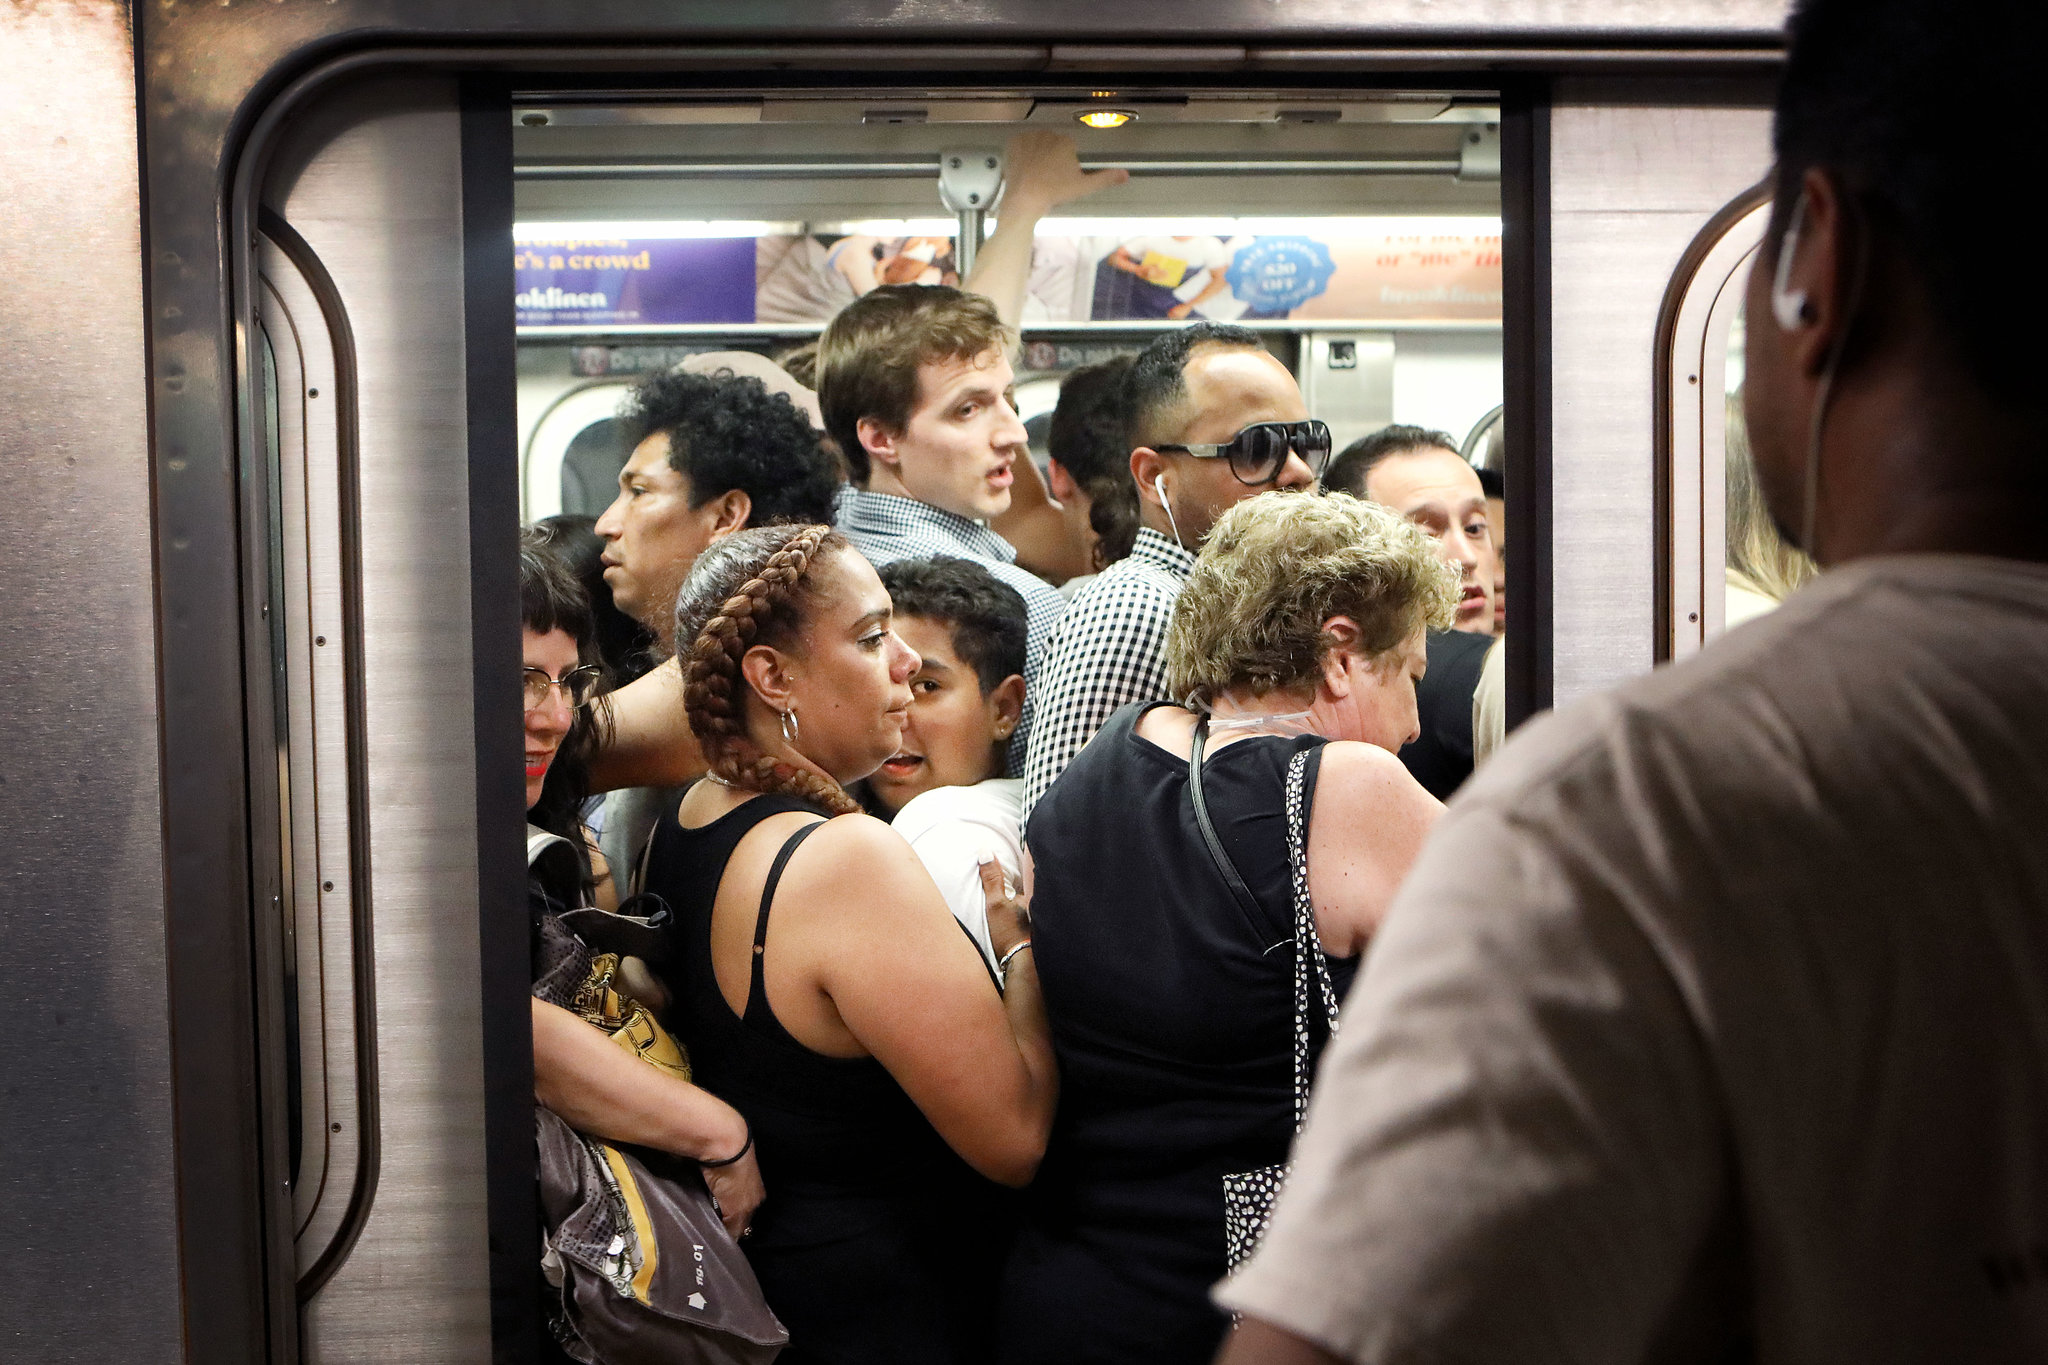

In [2]:
from IPython.display import Image
Image(filename='crowded-subway.jpeg',width=800)

## Solution

We aim to build a system to guide passenger to reach to carriage with more space.

Out system consists two steps: (1) people counting and (2) traffic routing.
1. This step operates by capturing real-time images of the subway, and then employing YOLO to count the number of passengers in each carriage. 
2. Upon acquiring the number data, we run an route balancing algorithm. This step provides real-time instructions to passengers to move towards more emtpy carriages. 

Through this approach, we are able to balance the load, ensuring a journey that is both more comfortable and more convenient for everyone.

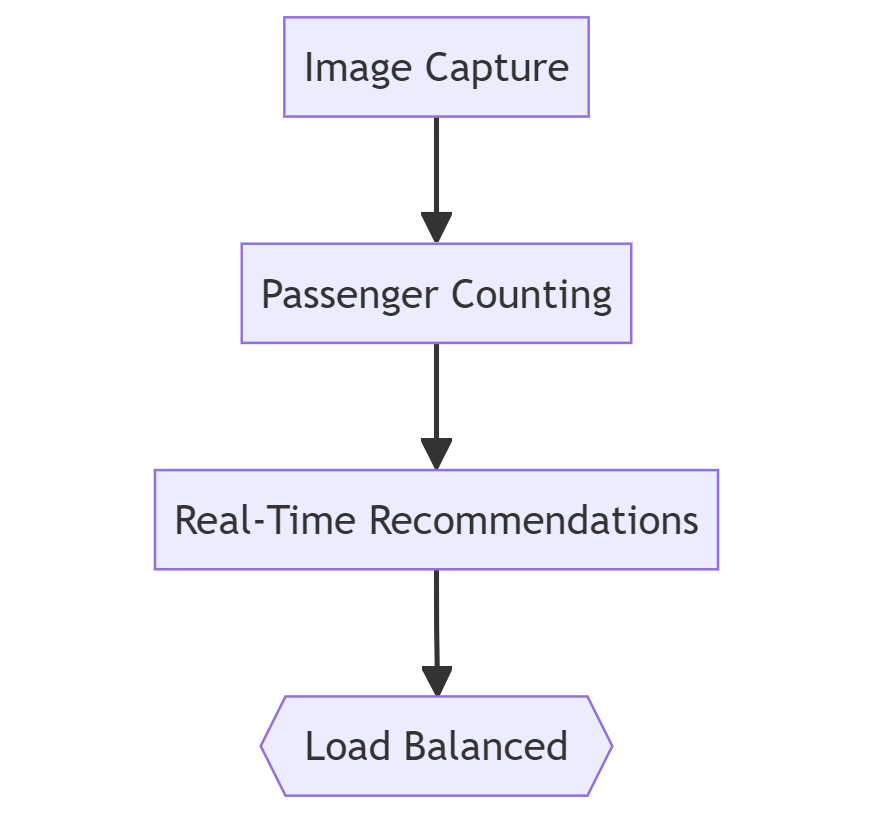

In [3]:
Image(filename='pipeline.jpg', width=400)

## Demo: overall system

### Step 1: people counting

In [4]:
from matplotlib import pyplot as plt

from utils import make_carriage_fig, read_level_lst, read_direction_lst, vis

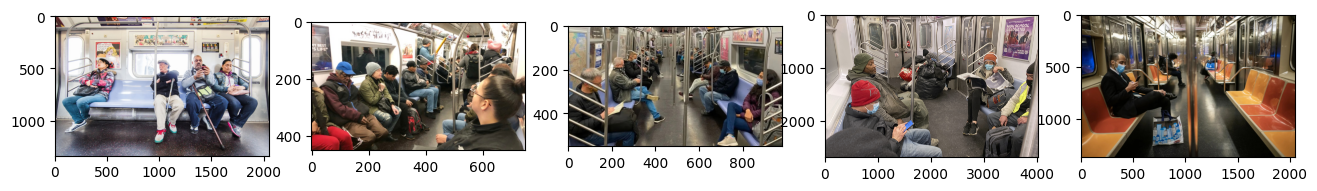

In [5]:
data_dir = "/Users/kai/src/nyc-ai-hackathon/subway-balancer/counter/data"

make_carriage_fig(data_dir)

In [6]:
!julia --proj=../counter ../counter/count.jl /Users/kai/src/nyc-ai-hackathon/subway-balancer/counter/data 5

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

copying output to local for the next step (and check its content)

In [7]:
!cp /Users/kai/src/nyc-ai-hackathon/subway-balancer/counter/data/subway-out.txt input.txt
!cat input.txt

4,11,7,4,3


### Step 2: routing

In [8]:
!java -cp /Users/kai/src/nyc-ai-hackathon/subway-balancer/balancer/balancer/out/artifacts/balancer_jar/balancer.jar SubwayCarRouting --input input.txt --output output.txt

Carriage_1: congestion level Empty, number of people 4, direction suggestion None
 Carriage_2: congestion level Moderate, number of people 11, direction suggestion Right
 Carriage_3: congestion level Mild, number of people 7, direction suggestion Right
 Carriage_4: congestion level Empty, number of people 4, direction suggestion None
 Carriage_5: congestion level Empty, number of people 3, direction suggestion None
Routing recommendations have been successfully written to the output file.


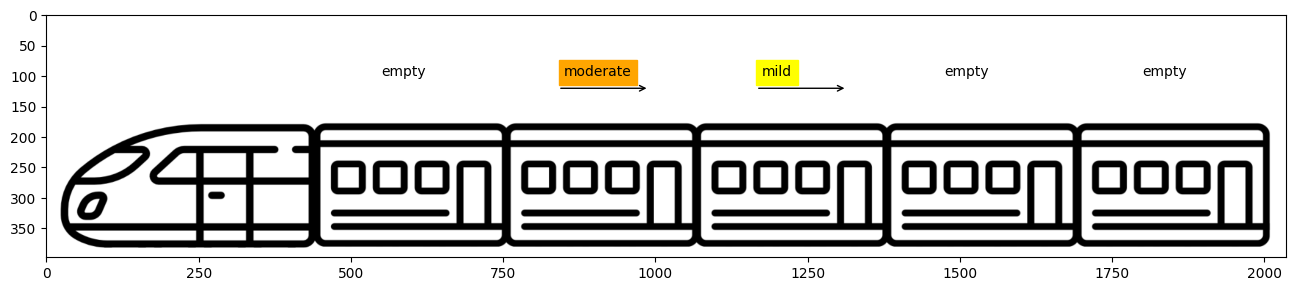

In [9]:
level_lst = read_level_lst("input.txt")
direction_lst = read_direction_lst('output.txt')
vis(level_lst, direction_lst)

## Routing algorithm: details

- **Initial  Check:** If the current carriage is empty ( <5 ) or is less crowded than adjacent carriages, it would recommend passengers to use this one.
- **Locate Less Crowded Carriage:** Identify the nearest carriage with fewer passengers on both left and right sides.
- **Generate Recommendations:** If less crowded carriages are found, recommend the direction towards the nearest one.


## Usage

According to the physical signs on the platform, passengers can know which way to go.

## Demo: more routing examples

In [10]:
!java -cp /Users/kai/src/nyc-ai-hackathon/subway-balancer/balancer/balancer/out/artifacts/balancer_jar/balancer.jar SubwayCarRouting --input example/input-1.txt --output example/output-1.txt

Carriage_1: congestion level Moderate, number of people 20, direction suggestion Right
 Carriage_2: congestion level Mild, number of people 6, direction suggestion None
 Carriage_3: congestion level Crowded, number of people 75, direction suggestion Right
 Carriage_4: congestion level Empty, number of people 4, direction suggestion None
 Carriage_5: congestion level Mild, number of people 8, direction suggestion Left
Routing recommendations have been successfully written to the output file.


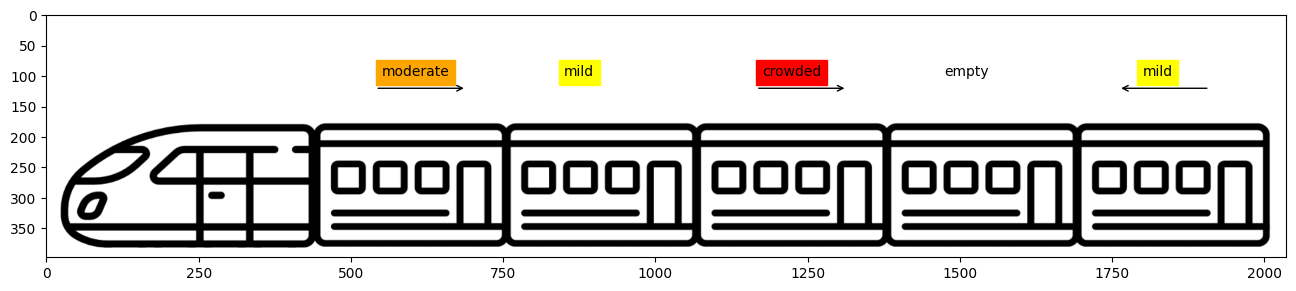

In [11]:
level_lst = read_level_lst("example/input-1.txt")
direction_lst = read_direction_lst('example/output-1.txt')
vis(level_lst, direction_lst)

In [12]:
!java -cp /Users/kai/src/nyc-ai-hackathon/subway-balancer/balancer/balancer/out/artifacts/balancer_jar/balancer.jar SubwayCarRouting --input example/input-2.txt --output example/output-2.txt

Carriage_1: congestion level Crowded, number of people 70, direction suggestion Right
 Carriage_2: congestion level Moderate, number of people 15, direction suggestion Right
 Carriage_3: congestion level Empty, number of people 3, direction suggestion None
 Carriage_4: congestion level Crowded, number of people 60, direction suggestion Left
 Carriage_5: congestion level Crowded, number of people 67, direction suggestion Left
Routing recommendations have been successfully written to the output file.


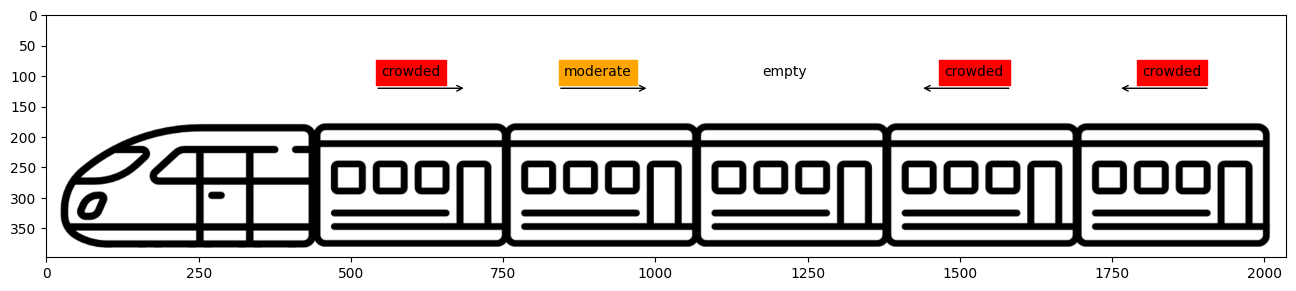

In [13]:
level_lst = read_level_lst("example/input-2.txt")
direction_lst = read_direction_lst('example/output-2.txt')
vis(level_lst, direction_lst)